In [ ]:
from os import chdir
from google.colab import drive
drive.mount('/content/drive')
chdir("/content/drive/MyDrive/thesis/mbti")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
%matplotlib inline
import itertools
import sklearn.metrics as metrics

#Loading our datasets

In [ ]:
Location = r''
mbti = pd.read_csv("/content/drive/MyDrive/thesis/(clean)mbti_expanded.csv")
mbti_clean = pd.read_csv("/content/drive/MyDrive/thesis/sentiment_augmented_mbti_clean_10_removed.csv")

In [ ]:
mbti.dropna(axis=0, inplace=True)
mbti.reset_index(drop=True, inplace=True)
mbti

,type,post,sentiment,sent_compound,sent_neg,sent_neu,sent_pos,e/i,s/n,t/f,j/p
0,entp,haha really best combo already likeminded intu...,1,0.8158,0.000,0.795,0.205,0,1,0,1
1,isfp,listen day get fuckin tired earworms last mont...,0,-0.5399,0.142,0.858,0.000,1,0,1,1
2,esfj,think obvious bias forum internet general rega...,1,0.0258,0.114,0.769,0.117,0,0,1,0
3,intj,that's exactly dopamine system numbed crave ef...,1,0.2732,0.095,0.754,0.151,1,1,0,0
4,intp,i'm trying amass data personality type like go...,0,-0.6110,0.130,0.822,0.048,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
408221,infj,know infj take 2.5 hour get house morning alwa...,1,0.4019,0.000,0.930,0.070,1,1,1,0
408222,infj,depressed melancholy age raised think book mat...,0,-0.9074,0.325,0.603,0.071,1,1,1,0
408223,intp,thanks response infj said want friend however ...,1,0.6124,0.050,0.789,0.160,1,1,0,1
408224,infj,researching type came across famous istps cele...,1,0.1901,0.000,0.941,0.059,1,1,1,0


In [ ]:
mbti_clean.dropna(axis=0, inplace=True)
mbti_clean.reset_index(drop=True, inplace=True)
mbti_clean

,type,post,word_count,e/i,s/n,t/f,j/p,sentiment,sent_compound,sent_neg,sent_neu,sent_pos
0,infp,infj ex asked bad wanting happy go meet new pe...,15.0,1,1,1,1,0,-0.4019,0.290,0.543,0.167
1,entp,hear sister laugh living room evil one guy tak...,14.0,0,1,0,1,0,-0.5423,0.437,0.287,0.276
2,infj,i'm also year-old infj really talk many people...,19.0,1,1,1,0,1,0.4588,0.000,0.857,0.143
3,entj,find kind pointless point lol wake every day t...,18.0,0,1,0,0,1,0.8074,0.058,0.581,0.361
4,infp,wow personal thought i'd contribute often try ...,15.0,1,1,1,1,1,0.1531,0.258,0.417,0.325
...,...,...,...,...,...,...,...,...,...,...,...,...
704379,estj,opt touch touching give pain pleasure glow utm...,20.0,0,0,0,0,0,-0.3400,0.228,0.634,0.138
704380,estj,prefer touch touching give annoyance joy burn ...,20.0,0,0,0,0,0,-0.0772,0.197,0.656,0.147
704381,estj,choose touch touching give bother pleasure sti...,21.0,0,0,0,0,1,0.5719,0.091,0.679,0.230
704382,estj,pick touch meet give pain pleasure burn utmost...,22.0,0,0,0,0,0,-0.3400,0.212,0.660,0.128


#Downsample the MBTI dataframe

In [ ]:
mbti['word_count'] = mbti['post'].str.split().str.len()
mbti.sort_values(by='word_count', ascending=True, inplace=True)
types = mbti['type'].unique()
v_c = dict(mbti['type'].value_counts())
minimum = mbti.loc[((mbti['type'] == 'estj') & (mbti['word_count'] > 10))].shape[0]

indexes_to_remove = []
for tp in types:
    to_remove = v_c[tp] - minimum
    for index in mbti[mbti['type'] == tp].iloc[:to_remove].index:
        indexes_to_remove.append(index)
mbti.drop(indexes_to_remove, inplace=True)
mbti.reset_index(drop=True, inplace=True)



# Clean up

In [ ]:
!pip install contractions
!pip install gibberish-detector
!pip install textstat


In [ ]:
 !gibberish-detector train /content/drive/MyDrive/thesis/big.txt > gibberish-detector.model

In [ ]:
import contractions
from gibberish_detector import detector

def contractions_fixer(text):
    # load the gibberish detection model
    Detector = detector.create_from_model('/content/drive/MyDrive/thesis/gibberish-detector.model')
    if not Detector.is_gibberish(text):
        return contractions.fix(text, slang=True)
    else:
        return np.nan  

In [ ]:
mbti['post'] = mbti['post'].apply(contractions_fixer) 

In [ ]:
mbti.dropna(axis=0, inplace=True)

In [ ]:
!pip install Unidecode

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import string
from unidecode import unidecode
import re
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]

tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)

In [ ]:
types = mbti['type'].unique()
def tokenize(s):
    return tokens_re.findall(s)


def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if tokens_re.search(token) else token.lower() for token in tokens]
    return tokens

def preproc(s):
	#s=emoji_pattern.sub(r'', s) # no emoji
	s= unidecode(s)
	POSTagger=preprocess(s)
	#print(POSTagger)

	post=' '.join(POSTagger)
	stop_words = set(stopwords.words('english')).union({'http', 'www', 'com', 'watch'})
	word_tokens = word_tokenize(post)
	#filtered_sentence = [w for w in word_tokens if not w in stop_words]
	filtered_sentence = []
	for w in POSTagger:
	    if w not in stop_words:
	        filtered_sentence.append(w)
	#print(word_tokens)
	#print(filtered_sentence)
	#stemmed_sentence=[]
	lemmatized_sentence = []
	#stemmer2 = SnowballStemmer("english", ignore_stopwords=True)
	lemmatizer = WordNetLemmatizer()
	for w in filtered_sentence:
		#stemmed_sentence.append(stemmer2.stem(w))
		lemmatized_sentence.append(lemmatizer.lemmatize(w))
	#print(stemmed_sentence)

	temp = ' '.join(c for c in lemmatized_sentence if c not in string.punctuation) 
	preProcessed=temp.split(" ")
	final=[]
	for i in preProcessed:
		if i not in final:
			if i.isdigit():
				pass
			else:
				if not any(tp in i for tp in types) and 'http' not in i:
					final.append(i)
	temp1=' '.join(c for c in final)
	#print(preProcessed)
	return temp1

In [ ]:
mbti['type'] = mbti['type'].str.lower()
mbti['post'] = mbti['post'].str.lower().apply(preproc)  
mbti.reset_index(drop=True, inplace=True)    
list(mbti['post']) 

In [ ]:
# mbti_clean['word_count'] = mbti_clean['post'].str.split().str.len()
# mbti_clean['post'].replace('', np.nan, inplace=True)
# mbti_clean['word_count'].replace([1,2,3,4,5,6,7,8,9,10], np.nan, inplace=True)
# mbti_clean.dropna(axis=0, inplace=True)
# mbti_clean.reset_index(drop=True, inplace=True)     

In [ ]:
# mbti_clean['e/i'] = np.where(mbti_clean['type'].str.find('i') >= 0, 1, 0)
# mbti_clean['s/n'] = np.where(mbti_clean['type'].str.find('n') >= 0, 1, 0)
# mbti_clean['t/f'] = np.where(mbti_clean['type'].str.find('f') >= 0, 1, 0)
# mbti_clean['j/p'] = np.where(mbti_clean['type'].str.find('p') >= 0, 1, 0)

In [ ]:
# mbti['e/i'] = np.where(mbti['type'].str.lower().str.find('i') >= 0, 1, 0)
# mbti['s/n'] = np.where(mbti['type'].str.lower().str.find('n') >= 0, 1, 0)
# mbti['t/f'] = np.where(mbti['type'].str.lower().str.find('f') >= 0, 1, 0)
# mbti['j/p'] = np.where(mbti['type'].str.lower().str.find('p') >= 0, 1, 0)

In [ ]:
# indexes = []
# for idx, e in enumerate(list(mbti['post'])):
#     if isinstance(e, float):
#         indexes.append(idx)
#         print("IN")


In [ ]:
# mbti = mbti.drop(index=indexes) 
# mbti.reset_index(drop=True, inplace=True) 

In [ ]:
# mbti = mbti.sample(frac=1)
# mbti.reset_index(drop=True, inplace=True)
# mbti.to_csv(r'/content/drive/MyDrive/thesis/(clean)mbti_expanded.csv', index = False, header = True)

# Sentiment Analysis

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def sentiment_analysis(s):
    sid = SentimentIntensityAnalyzer()
    result = sid.polarity_scores(s)
    if result['compound'] > 0:
        sentiment = 1
    else:
        sentiment = 0    
    return sentiment, result['compound'], result['neg'], result['neu'], result['pos'] 

In [ ]:
mbti['sentiment'], mbti['sent_compound'], mbti['sent_neg'], mbti['sent_neu'], mbti['sent_pos'] = zip(*mbti['post'].apply(sentiment_analysis))
mbti_clean['sentiment'], mbti_clean['sent_compound'], mbti_clean['sent_neg'], mbti_clean['sent_neu'], mbti_clean['sent_pos'] = zip(*mbti_clean['post'].apply(sentiment_analysis))

In [ ]:
# mbti.to_csv(r'/content/drive/MyDrive/thesis/mbti_expanded.csv', index = False, header = True)
# mbti_clean.to_csv(r'/content/drive/MyDrive/thesis/(sentiment)mbti_clean_10_removed.csv', index = False, header = True)

#Split train test

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, _, y_train, _ = train_test_split(mbti_clean['post'], mbti_clean['e/i'], test_size=0.10)
# X_train_sent, _, y_train_sent, _ = train_test_split(mbti_clean['sent_compound'], mbti_clean['e/i'], test_size=0.25)
# _, X_test, _, y_test = train_test_split(mbti['post'], mbti['e/i'], test_size=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(mbti['post'], mbti['s/n'], test_size=0.25, random_state=42)

In [ ]:
selected_train = mbti.iloc[X_train.index, :]
selected_test = mbti.iloc[X_test.index, :]
X_train_sent = np.concatenate((selected_train['sentiment'].values.reshape(-1,1), selected_train['sent_compound'].values.reshape(-1,1), selected_train['sent_neg'].values.reshape(-1,1), \
                               selected_train['sent_neu'].values.reshape(-1,1), selected_train['sent_pos'].values.reshape(-1,1)), axis=1)
X_test_sent = np.concatenate((selected_test['sentiment'].values.reshape(-1,1), selected_test['sent_compound'].values.reshape(-1,1), selected_test['sent_neg'].values.reshape(-1,1), \
                               selected_test['sent_neu'].values.reshape(-1,1), selected_test['sent_pos'].values.reshape(-1,1)), axis=1)

# Embeddings

## Fasttext

In [ ]:
def formatData_fasttext(path, X, y):
    f = open(path, "w")
    for post, label in zip(X, y):
        f.write(f"__label__{label} {post}\n")
    f.close()  

formatData_fasttext("/content/drive/MyDrive/thesis/data_train.txt", X_train, y_train)
formatData_fasttext("/content/drive/MyDrive/thesis/data_test.txt", X_test, y_test)  

In [ ]:
!pip install fasttext
import fasttext

     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3121916 sha256=e718c2662b15a71cb0bd9556fd0836c080af87dbd801a00b0721a5cc47418ac3
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
model = fasttext.train_supervised('/content/drive/MyDrive/thesis/data_train.txt', lr=0.025, epoch=15)

In [ ]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test('/content/drive/MyDrive/thesis/data_test.txt'))

N	4872
P@1	0.632
R@1	0.632


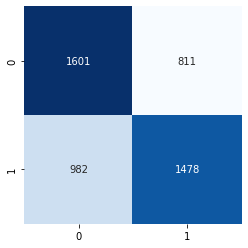

In [ ]:
pred = X_test.apply(lambda x: int(model.predict(x)[0][0].replace("__label__", "")))
# pred = model.predict(X_test.tolist())
conf_mat = metrics.confusion_matrix(y_test.values, pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

## Glove vectors

In [ ]:
import gensim.downloader as api

glove_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
from wordcloud import STOPWORDS
def textToEmbedding(txt, embeddings, rmvStopwords=False):
    if rmvStopwords:
        stopwords = set(STOPWORDS)
        txt  = [token for token in txt if token not in stopwords]
    
    ret_vec = np.zeros((1,embeddings.vector_size), dtype=float)
    # iterate through words and retrive embedding from pre-trained vectors
    counter = 0
    nf = 0
    for token in txt:
        if token not in embeddings.vocab.keys():
            nf = nf +1
            # print(token)
            continue
        
        ret_vec += embeddings[token]
        counter += 1

    # embedding for whole text is average of embedding of each word
    return (ret_vec / counter) if counter != 0 else ret_vec

In [ ]:
def recordsToVecs(df, embeddings):
    for idx, row in enumerate(df.iterrows()):
        record = row[1]

        record_vec = textToEmbedding(record['post'].split(), embeddings).reshape(1,-1)

        if idx == 0:
            ret_vec = record_vec
        else:
            ret_vec = np.concatenate((ret_vec, record_vec))
        if idx%1000 == 0:
            print(idx)
    return ret_vec

In [ ]:
X_train_w2v = recordsToVecs(train, glove_vectors)
# X_test_w2v = recordsToVecs(test, glove_vectors)

In [ ]:
 ret_vec = np.zeros((100000,glove_vectors.vector_size), dtype=float)
 temp = np.zeros((1,glove_vectors.vector_size), dtype=float)

In [ ]:
df = pd.DataFrame({"A": [1, 2], "B": [3.0, 4.5]})
df.to_csv("testNP.csv",index=False)

In [ ]:
testnp =  pd.read_csv("/content/drive/MyDrive/thesis/testNP.csv")


In [ ]:
ret_np = testnp.to_numpy()

In [ ]:
ret_np

array([[1. , 3. ],
       [2. , 4.5]])

In [ ]:
pd.DataFrame(ret_np).to_csv("/content/drive/MyDrive/thesis/testNP.csv", index=False)

In [ ]:
print(f'Train data shape: {X_train_w2v.shape}')

Train data shape: (1001, 100)


In [ ]:
print(f'Train data shape: {X_train_w2v.shape}')
print(f'Test data shape: {X_test_w2v.shape}')

## Creating the bag of words representations

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,2))

X_train_bow = X_train
X_test_bow = X_test

# learn the vocabulary only on training data
X_train_bow = bow_vectorizer.fit_transform(X_train_bow.tolist())
X_test_bow = bow_vectorizer.transform(X_test_bow.tolist())

## Creating the tf-idf representations


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

X_train_tfidf = X_train
X_test_tfidf = X_test

# learn the vocabulary only on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf.tolist())

In [ ]:
X_train_tfidf_sent = np.concatenate((X_train_tfidf.toarray(), X_train_sent), axis=1)
X_test_tfidf_sent = np.concatenate((X_test_tfidf.toarray(), X_test_sent), axis=1)

##Universal sentence encoder pretrained

In [ ]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
embed = hub.load(module_url)
print ("module %s loaded" % module_url)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
import tensorflow as tf
# # run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
# # Reduce logging output.
def use_embed(X, batch_size, total_size):
    X = X.tolist()
    idx = 0
    cut = batch_size
    if batch_size >= total_size:
         X_use = embed(X[idx:total_size])
         return X_use
    while(1):
        if idx == 0:
            X_use = embed(X[idx:cut])
            print(idx)    
        else:
            temp = embed(X[idx:cut])
            print(idx)
            X_use = tf.concat([X_use, temp], 0)
            if cut == total_size:
                return X_use

        idx += batch_size
        if cut+batch_size > total_size:
            cut += batch_size-((cut+batch_size) - total_size)
        else:
            cut += batch_size  

X_train_use = use_embed(X_train,100000,len(X_train))
X_test_use = use_embed(X_test,100000,len(X_test))

X_train_use_sent = np.concatenate((X_train_use, X_train_sent), axis=1)
X_test_use_sent = np.concatenate((X_test_use, X_test_sent), axis=1)

# BERT


In [ ]:
mbti['map_type'] = pd.factorize(mbti['type'])[0]
mbti

,type,post,sentiment,sent_compound,sent_neg,sent_neu,sent_pos,e/i,s/n,t/f,j/p,word_count,map_type
0,estj,first hate use cell phone ever get contact sec...,0,-0.1280,0.086,0.839,0.075,0,0,0,0,11,0
1,estj,think much easier female istp male estj way wo...,1,0.5994,0.000,0.803,0.197,0,0,0,0,11,0
2,estj,precursor really writing unless confused attem...,0,-0.5423,0.153,0.847,0.000,0,0,0,0,11,0
3,estj,think people get you like offer answer already...,0,-0.6608,0.172,0.828,0.000,0,0,0,0,11,0
4,estj,betrayed friend felt like garbage bad flutters...,0,-0.6808,0.297,0.478,0.225,0,0,0,0,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,isfp,french version voila petite amelie vous n'avez...,1,0.2500,0.000,0.944,0.056,1,0,1,1,31,8
19484,entp,som synden sveper han forbi latt att alska sta...,1,0.1027,0.064,0.864,0.073,0,1,0,1,32,10
19485,intp,Si Ye Du Shi Yi Yan Wang Bu Dao Tou De Man Bai...,1,0.8508,0.000,0.659,0.341,1,1,0,1,32,13
19486,estj,b c d e f g h j k l m n o p q r t you v w x y ...,0,-0.5106,0.125,0.818,0.057,0,0,0,0,33,0


In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
SEQ_LEN = 26  # we will cut/pad our sequences to a length of 26 tokens

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(mbti), SEQ_LEN))
Xmask = np.zeros((len(mbti), SEQ_LEN))

for i, sentence in enumerate(mbti['post']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)
    if i % 10000 == 0:
        print(i)  # do this so we can see some progress


arr = mbti['t/f'].values  # take sentiment column in df as array
labels = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
labels[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value        

0
10000


In [ ]:
import tensorflow as tf

BATCH_SIZE = 32  # we will use batches of 32

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(1000000).batch(BATCH_SIZE)
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.9  # 90-10 split

train = dataset.take(round(DS_LEN*SPLIT))  # get first 90% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 90% and keep final 10%

del dataset  # optionally, delete dataset to free up disk-space

In [ ]:
from transformers import TFAutoModel

# initialize cased BERT model
bert = TFAutoModel.from_pretrained('bert-base-uncased')



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(64)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.4)(X)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 26)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 26,                                          

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.BinaryCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(train, validation_data=val, epochs=100)

In [ ]:
temp = []
for i in val.take(62):
    for y in i[1]:
        temp.append(np.array(y))
labels = np.zeros((len(temp), 2))
for idx, label in enumerate(temp):
    labels[idx,:] = temp[idx]  

pred = model.predict(val)  
labels = [1 if i[1] == 1 else 0 for i in labels]
pred = [1 if i[1] >= 0.5 else 0 for i in pred]
# print(f"F1 score: {metrics.f1_score(y_test, pred, average='micro').round(2)}")
# print(f"Accuracy: {(100*metrics.accuracy_score(y_test, pred)).round(2)} %")
conf_mat = metrics.confusion_matrix(labels, pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
plt.plot(history.history['val_accuracy'], label = 'val-accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val-loss')
plt.legend()
plt.grid()

In [ ]:
print(model.evaluate(val, return_dict=True))

In [ ]:
print(np.mean(history.history['loss']))
print(np.mean(history.history['accuracy']))


In [ ]:
tf.saved_model.save(model, '/content/drive/MyDrive/thesis/model_e_i')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/thesis/model_e_i.h5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/thesis/model_e_i.h5/assets


In [ ]:
from keras.models import load_model
loaded_model =  tf.saved_model.load("/content/drive/MyDrive/thesis/model_e_i")

#Plots

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
def scatter_3d(X,y,tp):
    pca = PCA(n_components=3)
    svd = TruncatedSVD(n_components=3)
    if tp == "pca":
        model = pca
    else:
        model = svd    
    result = model.fit_transform(X)
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs= result[:,0],
        ys= result[:,1],
        zs= result[:,2],
        c= y,
        cmap='tab10'
    )
    ax.set_xlabel('one')
    ax.set_ylabel('two')
    ax.set_zlabel('three')
    plt.show()




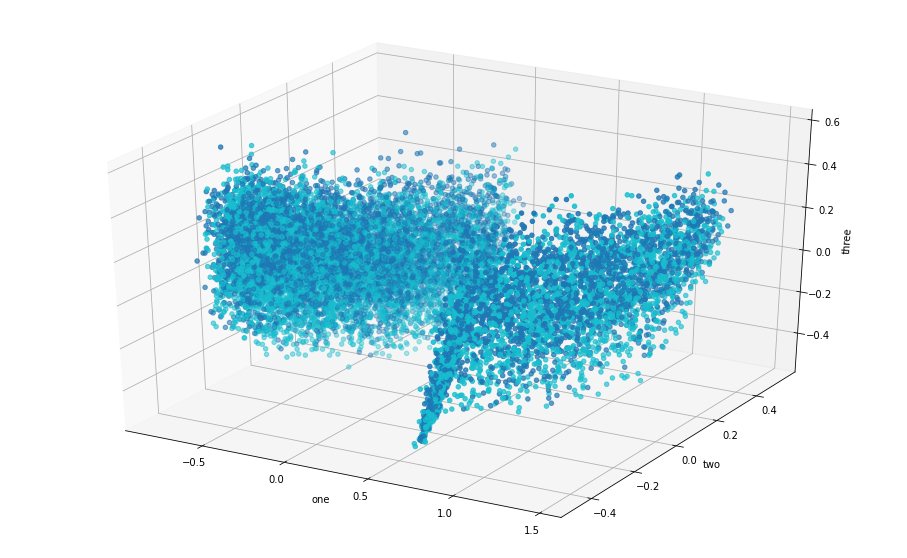

In [ ]:
scatter_3d(X_train_use_sent, y_train, "pca")

In [ ]:
scatter_3d(X_test_bow, y_test, "svd")

# Classify

In [ ]:
def classify(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    # predict labels of test set
    pred = model.predict(X_test)
    # print the results
    print(f"F1 score: {metrics.f1_score(y_test, pred, average='micro').round(2)}")
    print(f"Accuracy: {(100*metrics.accuracy_score(y_test, pred)).round(2)} %")
    conf_mat = metrics.confusion_matrix(y_test, pred)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

##LogReg - SVM - RandomForrest - GaussianNB - MultinomialNB

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
mult = MultinomialNB()
logReg = LogisticRegression(max_iter=1000)
svm = SVC()
randForest = RandomForestClassifier(n_jobs=-1)

F1 score: 0.65
Accuracy: 65.02 %


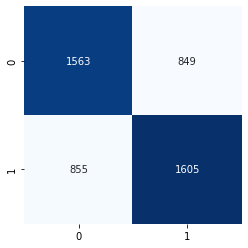

In [ ]:
classify(logReg, X_train_use_sent, X_test_use_sent, y_train, y_test) #for e/i

F1 score: 0.66
Accuracy: 65.7 %


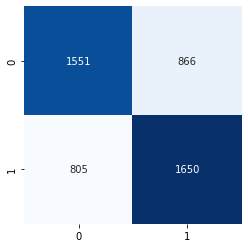

In [ ]:
classify(logReg, X_train_use_sent, X_test_use_sent, y_train, y_test) #for s/n

F1 score: 0.58
Accuracy: 58.07 %


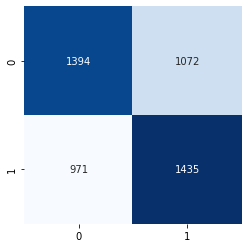

In [ ]:
classify(logReg, X_train_use_sent, X_test_use_sent, y_train, y_test) #for t/f

F1 score: 0.56
Accuracy: 56.49 %


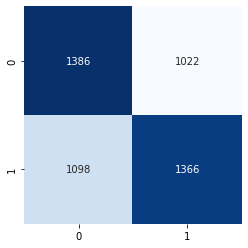

In [ ]:
classify(logReg, X_train_use_sent, X_test_use_sent, y_train, y_test) #for j/p

Average = 61.32%

##Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

model_gbm = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.0125,
                                       max_depth=4,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=30,
                                       max_features='log2',
                                       verbose=1)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3855           0.0004            2.86m
         2           1.3846           0.0005            2.89m
         3           1.3841           0.0005            2.87m
         4           1.3831           0.0007            2.87m
         5           1.3817           0.0008            2.87m
         6           1.3809           0.0012            2.91m
         7           1.3802           0.0005            2.94m
         8           1.3791           0.0005            2.93m
         9           1.3784           0.0005            2.92m
        10           1.3777           0.0007            2.90m
        20           1.3704           0.0004            2.87m
        30           1.3628           0.0006            2.87m
        40           1.3553           0.0007            2.85m
        50           1.3476           0.0004            2.82m
        60           1.3433           0.0002            2.81m
       

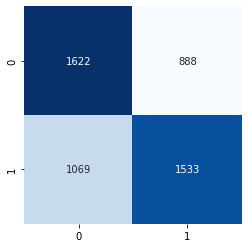

In [ ]:
classify(model_gbm, X_train_use_sent, X_test_use_sent, y_train, y_test) #for e/i

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3852           0.0006            1.99m
         2           1.3843           0.0009            2.07m
         3           1.3837           0.0005            2.10m
         4           1.3827           0.0006            2.11m
         5           1.3816           0.0007            2.13m
         6           1.3810           0.0006            2.11m
         7           1.3800           0.0007            2.11m
         8           1.3788           0.0005            2.16m
         9           1.3781           0.0010            2.17m
        10           1.3770           0.0005            2.17m
        20           1.3691           0.0004            2.12m
        30           1.3594           0.0008            2.15m
        40           1.3532           0.0003            2.13m
        50           1.3425           0.0002            2.13m
        60           1.3347           0.0004            2.12m
       

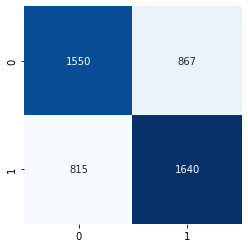

In [ ]:
classify(model_gbm, X_train_use_sent, X_test_use_sent, y_train, y_test) #for s/n

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3856           0.0002            2.53m
         2           1.3852           0.0002            2.70m
         3           1.3847           0.0003            2.69m
         4           1.3842           0.0002            2.66m
         5           1.3837           0.0001            2.67m
         6           1.3837           0.0000            2.65m
         7           1.3831           0.0001            2.73m
         8           1.3826           0.0001            2.72m
         9           1.3824           0.0001            2.73m
        10           1.3819           0.0002            2.73m
        20           1.3772           0.0003            2.75m
        30           1.3734           0.0001            2.75m
        40           1.3700           0.0002            2.73m
        50           1.3660           0.0001            3.41m
        60           1.3628           0.0001            4.10m
       

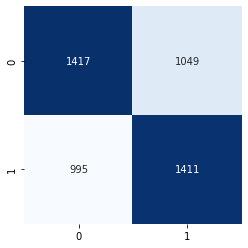

In [ ]:
classify(model_gbm, X_train_use_sent, X_test_use_sent, y_train, y_test) #for t/f

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3857           0.0002            4.02m
         2           1.3851           0.0002            4.03m
         3           1.3849           0.0001            3.98m
         4           1.3843           0.0001            3.94m
         5           1.3838           0.0001            4.07m
         6           1.3834           0.0001            4.04m
         7           1.3832           0.0002            4.04m
         8           1.3827           0.0001            3.99m
         9           1.3825           0.0002            3.96m
        10           1.3820           0.0002            4.07m
        20           1.3787           0.0001            4.22m
        30           1.3747           0.0001            3.96m
        40           1.3712          -0.0000            3.63m
        50           1.3682           0.0001            3.42m
        60           1.3646           0.0001            3.27m
       

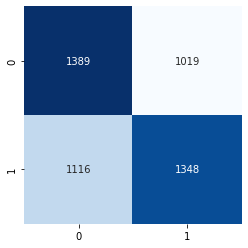

In [ ]:
classify(model_gbm, X_train_use_sent, X_test_use_sent, y_train, y_test) #for j/p

Average = 60.855%

##Sequential

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

In [ ]:
model = Sequential()

model.add(Dense(64, activation='relu',input_dim=X_train_use_sent.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

F1 score: 0.66
Accuracy: 65.52 %


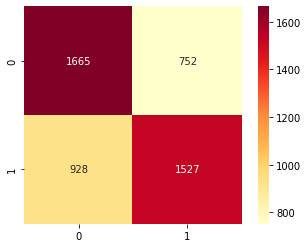

In [ ]:
history = model.fit(X_train_use_sent,y_train, epochs=45,batch_size=64)
pred = (model.predict(X_test_use_sent) > 0.5).astype(int)
print(f"F1 score: {metrics.f1_score(y_test, pred, average='micro').round(2)}")
print(f"Accuracy: {(100*metrics.accuracy_score(y_test, pred)).round(2)} %")
conf_mat = metrics.confusion_matrix(y_test, pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='YlOrRd', fmt='d', cbar=True)